# Loan Data from Prosper

## Investigation Overview

In this investigation, I wanted to look at the Loan amounts and top states and categories based on number of loans. Also I will show what affects the loan status and the APR of the borrower.


## Dataset Overview

This data set contains 113,937 loans with 81 variables on each loan, including loan amount, borrower rate (or interest rate), current loan status, borrower income, and many others.

In [4]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [5]:
# load in the dataset into a pandas dataframe, print statistics
loans = pd.read_csv('prosperLoanData.csv')
base_color = sb.color_palette()[0]

In [6]:
#convert date columns to datetime data type
loans['ListingCreationDate']=pd.to_datetime(loans['ListingCreationDate'])
loans['ClosedDate']=pd.to_datetime(loans['ClosedDate'])
loans['DateCreditPulled']=pd.to_datetime(loans['DateCreditPulled'])
loans['LoanOriginationDate']=pd.to_datetime(loans['LoanOriginationDate'])
loans['FirstRecordedCreditLine']=pd.to_datetime(loans['FirstRecordedCreditLine'])


#Lets drop some columns not to disturb us and to focus to a lower number of columns.
loans2 = loans.drop(columns = [
'CreditGrade',
'BorrowerRate',
'LenderYield',
'EstimatedReturn' ,
'EstimatedEffectiveYield',
'EstimatedLoss',
'EstimatedLoss',
'EstimatedLoss',
'ProsperRating (numeric)',
'ProsperRating (Alpha)',
'ProsperScore',
'CurrentlyInGroup',
'GroupKey',
'CreditScoreRangeLower',
'CreditScoreRangeUpper',
'TotalCreditLinespast7years',
'OpenRevolvingAccounts',
'OpenRevolvingMonthlyPayment',
'InquiriesLast6Months',
'TotalInquiries',
'PublicRecordsLast10Years',
'PublicRecordsLast12Months',
'RevolvingCreditBalance',
'LoanKey',
'TotalProsperLoans',
'TotalProsperPaymentsBilled',
'OnTimeProsperPayments',
'ProsperPaymentsLessThanOneMonthLate',
'ProsperPaymentsOneMonthPlusLate',
'ProsperPrincipalBorrowed',
'ProsperPrincipalOutstanding',
'ScorexChangeAtTimeOfListing',
'LoanFirstDefaultedCycleNumber',
'MonthlyLoanPayment',
'InvestmentFromFriendsCount',
'InvestmentFromFriendsAmount',
'Investors'], axis=1)


#We found some records with Null Borrower State. Not too much comparing to number of records... Let's drop them
loans2=loans2.dropna(subset=['BorrowerState'])



In [7]:
cat = { 0 : "Not Available", 1 : "Debt Consolidation", 2 : "Home Improvement", 3 : "Business", 4 : "Personal Loan"
       , 5 : "Student Use", 6 : "Auto", 7 : "Other", 8 : "Baby&Adoption", 9 : "Boat", 10 : "Cosmetic Procedure"
       , 11 : "Engagement Ring", 12 : "Green Loans", 13 : "Household Expenses", 14 : "Large Purchases", 15 : "Medical/Dental"
       , 16 : "Motorcycle", 17 : "RV", 18 : "Taxes", 19 : "Vacation", 20 : "Wedding Loans" }

#create a list for loans category description
cat_list = []
for i in loans2['ListingCategory (numeric)']:
    cat_list.append(cat[i])

loans2['ListingCategory (cat)'] = cat_list


#creating New Column for Employment Status

EmploymentStatus_list = []
for i in loans2['EmploymentStatus']:
    if (i =='Employed') or (i =='Full-time') or (i =='Self-employed') or (i =='Part-time'): 
        EmploymentStatus_list.append('Employed')
    else:
        EmploymentStatus_list.append('Not Employed / Other')
    
loans2['EmploymentStatus2'] = EmploymentStatus_list




#Lets combile Not Available & Others in one category
loans2['ListingCategory (cat)']=loans2['ListingCategory (cat)'].replace('Not Available', 'Other / Not Available').replace('Other', 'Other / Not Available')


## Distribution of Loan Amount

Loan Amount in the dataset Varies from 1000 USD to 35000 USD. Customers tend to take loans with values with multiples of 5000, a lot of loans have values 5000,10000,15000 and also 20000 and 25000. Small number of loans have amount more than 25000.

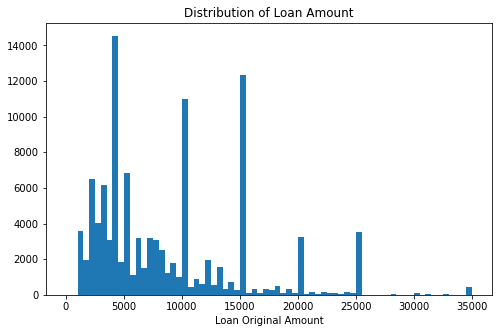

In [8]:
plt.figure(figsize=[8, 5])
binsize = 500
bins = np.arange(0, loans2['LoanOriginalAmount'].max()+binsize, binsize)
plt.hist(data = loans2, x = 'LoanOriginalAmount', bins = bins)
plt.xlabel('Loan Original Amount');
plt.title('Distribution of Loan Amount');

## Top loan category for each state

For each of the top 6 states, we show the top 10 loan categories. 
Calefornia has the most loans followed by Texas.
Debt Consolidation loan type is the most common loan type requested by customers followed by Business and Home improvement

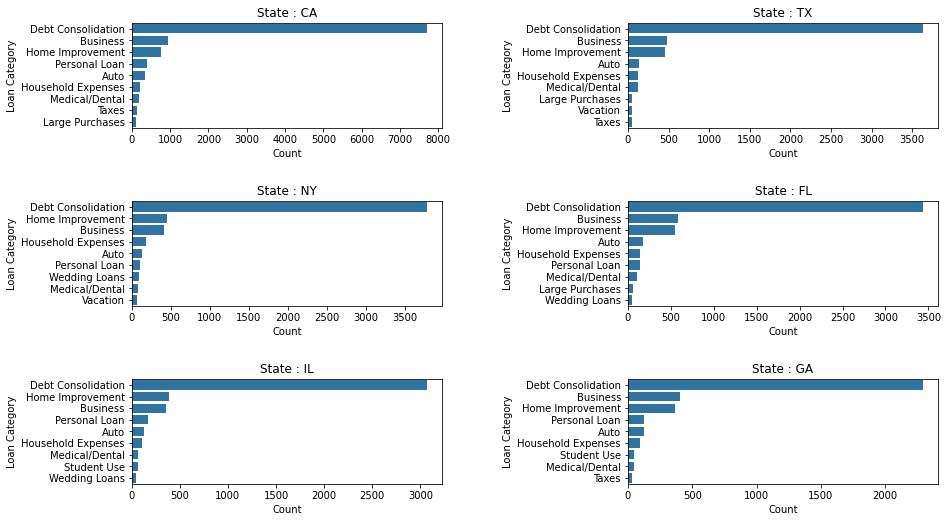

In [22]:
#Get only top 6 states
loans2_sub = loans2.loc[loans2['BorrowerState'].isin(list(loans2['BorrowerState'].value_counts().iloc[:6].index))]
Top6_States = list(loans2_sub['BorrowerState'].value_counts().index)
ordered_states = pd.api.types.CategoricalDtype(ordered=True, categories=Top6_States)
loans2_sub['BorrowerState'] = loans2_sub['BorrowerState'].astype(ordered_states)

plt.figure(figsize = [14,8])
for i in range(loans2_sub['BorrowerState'].value_counts().shape[0]):
    state = loans2_sub['BorrowerState'].value_counts().index[i]
    plt.subplot(3,2,i+1)
    loans2_sub_sub = loans2_sub[loans2_sub['BorrowerState'] == state]
    loans2_sub_sub = loans2_sub_sub[loans2_sub_sub['ListingCategory (cat)']!='Other / Not Available']
    #Get only top 10 Categories
    sb.countplot(data =loans2_sub_sub, y='ListingCategory (cat)',
          order=loans2_sub_sub['ListingCategory (cat)'].value_counts().iloc[:9].index, color = base_color);
    #plt.yticks(rotation=45);
    plt.title ('State : '+state)
    plt.ylabel('Loan Category')
    plt.xlabel('Count')
plt.subplots_adjust(left=0.1,
                bottom=0.1, 
                right=0.9, 
                top=0.9, 
                wspace=0.6, 
                hspace=0.7)

## Employment Status vs. Loan Status

For Employed people, we found out they have lower percentage for their loans to be defaulted or to be charged off than unemployed people which make sense. The employed people have higher probability to pay their loans.

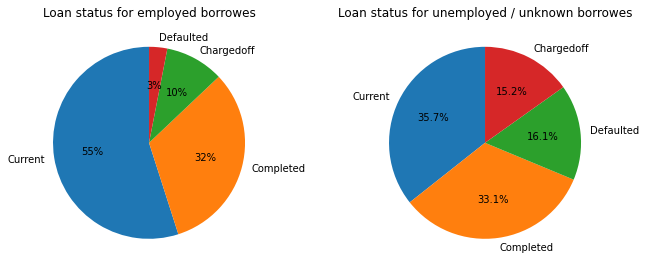

In [10]:
loans_sub = loans2.loc[loans2['LoanStatus'].isin(list(loans2['LoanStatus'].value_counts().iloc[:4].index))]

plt.figure(figsize = [10,8])
plt.subplot (1,2,1)
loans_employed = loans_sub[loans_sub['EmploymentStatus2'] == 'Employed']
sorted_counts = loans_employed['LoanStatus'].value_counts()
plt.pie(sorted_counts, labels = sorted_counts.index,startangle = 90,autopct='%1.0f%%');
plt.title('Loan status for employed borrowes')

plt.subplot (1,2,2)
loans_employed = loans_sub[loans_sub['EmploymentStatus2'] == 'Not Employed / Other']
sorted_counts = loans_employed['LoanStatus'].value_counts()
plt.pie(sorted_counts, labels = sorted_counts.index,startangle = 90,autopct='%1.1f%%');

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.title('Loan status for unemployed / unknown borrowes');


## The ratio of delequent loans for each occupation

For Each occupation (job title) of the top 24, we show the ratio of delequent and non delequent loans. We found out that Nurse, analyst and computer programmer have low delequencies ratio. Clerical and Sales have high delequencies ratio.

In [11]:

#discard cancelled and Final Payment In Progress
loans_sub_loanstatus = loans2[(loans2['LoanStatus'] != 'FinalPaymentInProgress')&(loans2['LoanStatus'] != 'Cancelled')]

#Group to Delequent and Not Delequent
loans_sub_loanstatus['LoanStatusGroup'] = loans_sub_loanstatus['LoanStatus'].replace('Chargedoff', 'Delequent')\
    .replace('Defaulted','Delequent').replace('Current', 'Not Delequent')\
    .replace('Completed', 'Not Delequent')\
    .replace('Past Due (1-15 days)', 'Delequent')\
    .replace('Past Due (31-60 days)', 'Delequent')\
    .replace('Past Due (61-90 days)', 'Delequent')\
    .replace('Past Due (91-120 days)', 'Delequent')\
    .replace('Past Due (16-30 days)', 'Delequent')\
    .replace('Past Due (>120 days)', 'Delequent')




labels = ['Not Delequent','Delequent']
sizes = [88.4, 10.6, 0.7, 0.3]
colors = ['#ff9999','#66b3ff']


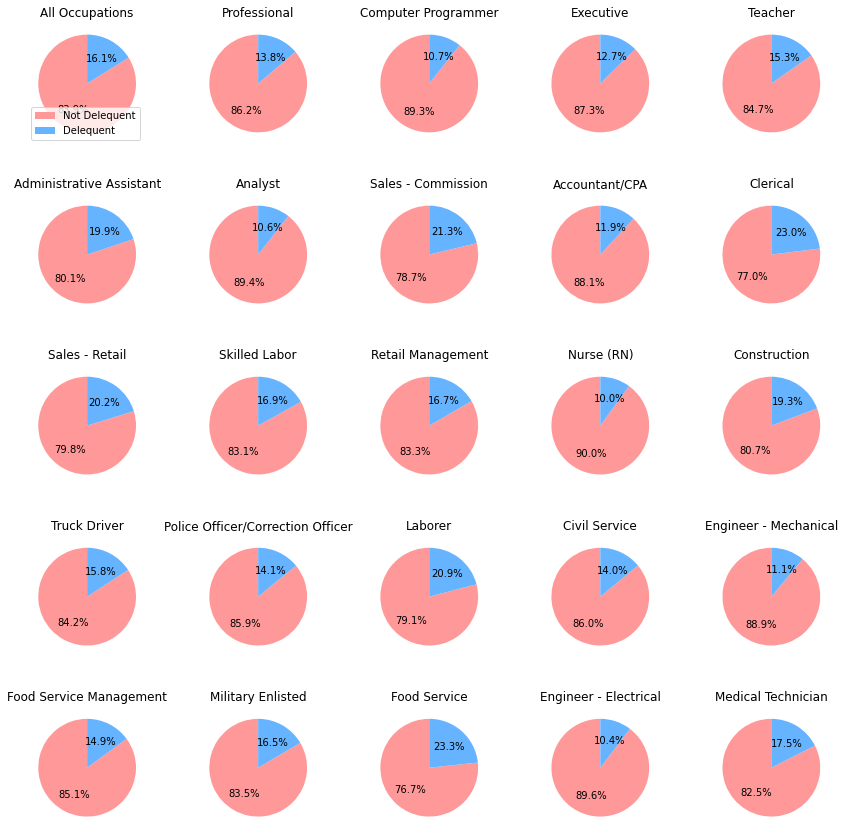

In [12]:
plt.figure(figsize = [14,14])

patches, texts = plt.pie(sizes, colors=colors, startangle=90)

plt.subplot(5,5,1)
plt.legend(patches, labels, loc="best")
vc = loans_sub_loanstatus['LoanStatusGroup'].value_counts()
plt.pie(vc, startangle = 90,  colors=colors,autopct='%1.1f%%')
plt.xticks(rotation=45);
plt.title('All Occupations')

counter = 2
occupation_order = loans2[loans2['Occupation']!='Other']['Occupation'].value_counts().index
for i in occupation_order[:24]:
    plt.subplot(5,5,counter)
    #loans_sub = loans2.loc[loans2['LoanStatus'].isin(list(loans2['LoanStatus'].value_counts().iloc[:4].index))]
    vc = loans_sub_loanstatus[loans_sub_loanstatus['Occupation']== i]['LoanStatusGroup'].value_counts()
    plt.pie(vc,explode=None, startangle = 90,autopct='%1.1f%%',  colors = colors)
    plt.xticks(rotation=45);
    counter+=1
    plt.title(i)


plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

## APR vs Employment status & Home Owning

We can see that -on average- the unemployed people have higher APR (Anual Percentage Rate) for their loans. Also the people who don't own a home have higher average APR (Anual Percentage Rate) for their loans.

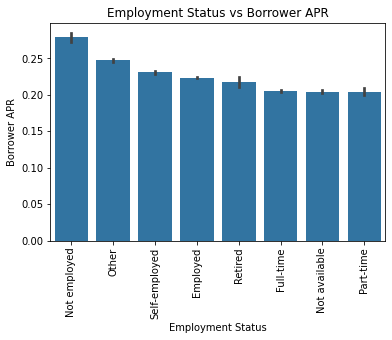

In [13]:
order_by_APR = pd.DataFrame(loans2.groupby(['EmploymentStatus']).mean()['BorrowerAPR']).sort_values(by=['BorrowerAPR'], ascending=False).index
sb.barplot(data=loans2,x='EmploymentStatus', y = 'BorrowerAPR', order = order_by_APR, color = base_color);
plt.xticks(rotation=90);
plt.xlabel('Employment Status');
plt.ylabel('Borrower APR');
plt.title ('Employment Status vs Borrower APR');

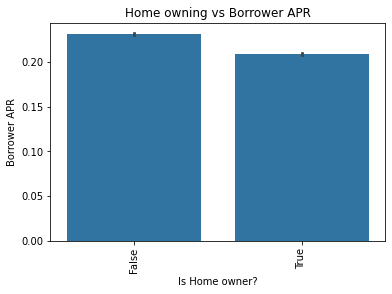

In [14]:
sb.barplot(data=loans2,x='IsBorrowerHomeowner', y = 'BorrowerAPR', color = base_color);
plt.xticks(rotation=90);
plt.xlabel('Is Home owner?');
plt.ylabel('Borrower APR');
plt.title ('Home owning vs Borrower APR');

## APR vs State

We show each state and the average APR (Anual percentage rate). We can see that ME and IA states have a low ARP and AL has the highest ARP in average.

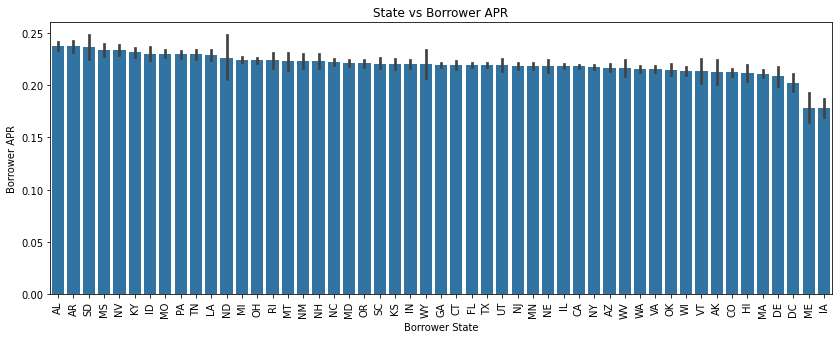

In [15]:
order_by_APR = pd.DataFrame(loans2.groupby(['BorrowerState']).mean()['BorrowerAPR']).sort_values(by=['BorrowerAPR'], ascending=False).index
plt.figure(figsize = [14,5])
sb.barplot(data=loans2,x='BorrowerState', y = 'BorrowerAPR', color = base_color, order = order_by_APR);
plt.xticks(rotation=90);
plt.xlabel('Borrower State');
plt.ylabel('Borrower APR');
plt.title ('State vs Borrower APR');